# Lab 1: Regression

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

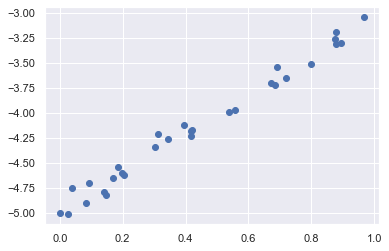

In [2]:
rng = np.random.RandomState(1)
x =  rng.rand(30)
y = 2 * x - 5 + 0.1* rng.randn(30)
plt.scatter(x, y);

Fill in the MultivariateLinearRegression class whose method fit takes a matrix $X$ and an array $y$ as input and returns an array of coefficients

In [3]:
class MultivariateLinearRegression():
    # Class for least-squares linear regression:

    def __init__(self,):
        self.coef_ = None
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X
        
        # Update self.coef_
        
        self.coef_ = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y
        
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X

        y_pred = X_aug @ self.coef_
        return(y_pred)

Try your model on the data and plot the data points and the fitted line:

[-4.97604684  1.92920553]


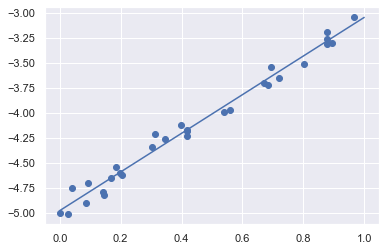

In [4]:
model = MultivariateLinearRegression()

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 1, 1000)
yfit = model.predict(xfit[:, np.newaxis])

print(model.coef_)

plt.scatter(x, y)
plt.plot(xfit, yfit);

Print the scope and the intercept:

In [5]:
print("Model slope:    ")
print("Model intercept:")

Model slope:    
Model intercept:


We see that the results are very close to the inputs, as we might hope.

Of course our linear regression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building a toy example:

In [6]:
rng = np.random.RandomState(1)
X = 3 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.coef_) # perfect fitting

[ 0.5  1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can our estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.

The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(5, include_bias=False) # with or without intercept
poly.fit_transform(x[:, None])

array([[   2.,    4.,    8.,   16.,   32.],
       [   3.,    9.,   27.,   81.,  243.],
       [   4.,   16.,   64.,  256., 1024.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression

With this transform, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

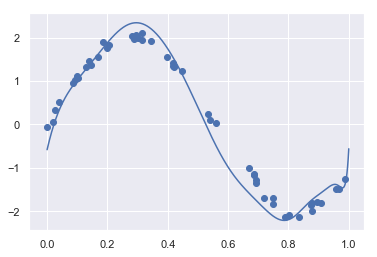

In [12]:
rng = np.random.RandomState(1)
x = rng.rand(50)
y = 2 * np.sin(1.8*np.pi*x) + 0.1 * rng.randn(50)

poly = PolynomialFeatures(25, include_bias=False)
polyx = poly.fit_transform(x[:, None])
polyxfit = poly.fit_transform(xfit[:, None])
model.fit(polyx, y)
yfit  = model.predict(polyxfit)

plt.scatter(x, y)
plt.plot(xfit, yfit);

Try with different maximum degrees. Our linear model can provide an excellent fit to this non-linear data!

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting and numeric problems.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.

 Fill in the following class:

In [14]:
class RidgeRegularization():
    # Class for least-squares linear regression:

    def __init__(self, alpha):
        self.coef_ = None
        self.alpha_ = alpha
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X
        
        # Update self.coef_
        self.coef_ = np.linalg.inv(X_aug.T @ X_aug + self.alpha_ * np.eye(num_features+1)) @ X_aug.T @ y
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X

        y_pred = X_aug @ self.coef_
        return(y_pred)

Try the model in our data:

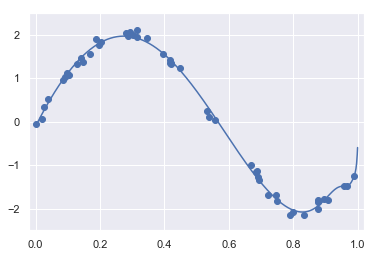

In [16]:
poly = PolynomialFeatures(300, include_bias=False) 
holu = poly.fit_transform(x[:, None])  
model = RidgeRegularization(0.0001) 
model.fit(holu, y)

plt.scatter(x[:, np.newaxis], y)
prediccion = model.predict(poly.fit_transform(xfit[:, None]))
plt.plot(xfit, prediccion)

plt.xlim(-0.02, 1.02)
plt.ylim(-2.5, 2.5);

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.

### Lasso regression ($L_1$ Regularization)

In [17]:
from sklearn.linear_model import LinearRegression

class LassoRegression():
    # Class for least-squares linear regression:

    def __init__(self, alpha):
        self.coef_ = None
        self.alpha_ = alpha
        
    def soft_threshold(self, alpha, beta):
        if beta > alpha:
            return beta - alpha
        elif beta < -alpha:
            return beta + alpha
        else:
            return 0
    
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X
        X = X_aug
       
        self.coef_ = np.zeros((num_features+1, ))
        
        self.coef_[0] = np.mean(y)
        
        convergence = False
        
        while not(convergence):
            newcoef = np.copy(self.coef_)
            for j in range(1, num_features+1):
                exclude_j = np.array(range(num_features+1)) != j
                partial_residuals = y - X[:, exclude_j] @ newcoef[exclude_j] 
                beta = self.soft_threshold(self.alpha_, X[:, j] @ partial_residuals)/(X[:, j]**2).sum()
                newcoef[j] = beta
            newcoef[0] = np.sum(y - (X[:, 1:] @ newcoef[1:]))/(X.shape[0])
            convergence = np.inner(self.coef_-newcoef, self.coef_-newcoef) < 10**(-5) 
            self.coef_ = np.copy(newcoef)
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X

        y_pred = X_aug @ self.coef_
        return(y_pred)

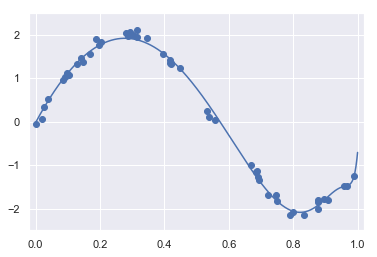

In [20]:
model = LassoRegression(0.0001)
poly = PolynomialFeatures(300, include_bias=False) 
holu = poly.fit_transform(x[:, None])  

model.fit(holu, y)

plt.scatter(x[:, np.newaxis], y)
prediccion = model.predict(poly.fit_transform(xfit[:, None]))
plt.plot(xfit, prediccion)

plt.xlim(-0.02, 1.02)
plt.ylim(-2.5, 2.5);

## Robust regression

In [7]:
class RobustRegression():
    # Class for least-squares linear regression:

    def __init__(self, potential, k):
        self.coef_ = None
        self.potencial_ = potential
        self.k_ = k
        
    def mad(self, x):
        return(np.median(np.abs(x-np.median(x))))
        
    def weight_function(self, x, potential, k):
        if potential == "huber":
            if np.abs(x)<=k:
                return(1)
            else:
                return(k/np.abs(x))
        if potential == "bisquare":
            if np.abs(x)<=k:
                return((1-(x/k)**2)**2)
            else:
                return(0)
    
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X
        
        self.coef_ = np.linalg.inv(X_aug.T @ X_aug ) @ X_aug.T @ y
        
        convergence = False
        
        while not(convergence):
        
            residuals = y - X_aug @ self.coef_
            norm_residuals = residuals/self.mad(residuals)
            weight_matrix = np.diag(np.array([self.weight_function(ri, self.potencial_, self.k_) for ri in norm_residuals]))
            newcoef = np.linalg.inv(X_aug.T @ weight_matrix @ X_aug ) @ X_aug.T @ weight_matrix @ y
            
            convergence = np.inner(self.coef_-newcoef, self.coef_-newcoef) < 10**(-5) 
            self.coef_ = np.copy(newcoef)
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        num_samples, num_features =  X.shape
        X_aug = np.ones((num_samples, num_features+1))
        X_aug[:, 1:] = X

        y_pred = X_aug @ self.coef_
        return(y_pred)

Try it in the following data and compare with the performance of the different models:

[-5.0223195   2.02540092]


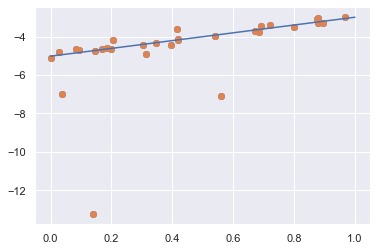

In [8]:
np.random.seed(300)
rng = np.random.RandomState(1)
x =  rng.rand(30)
y = 2 * x - 5 + 0.1* np.random.standard_cauchy(30)
plt.scatter(x, y);

#model = MultivariateLinearRegression()
model = RobustRegression("huber", 1.0)

model.fit(x[:, np.newaxis], y)

print(model.coef_)

xfit = np.linspace(0, 1.0, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we joinned the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.

We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

Let's start by loading the dataset:

In [23]:
import pandas as pd
daily = pd.read_csv('data.csv', index_col='Date', parse_dates=True)

With this in place, we can choose the columns to use, and fit a linear regression model to our data:

In [24]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)']
X = daily[column_names]
y = daily['Total']

from sklearn import preprocessing

xx = X.values.astype(float) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xx)

model = RidgeRegularization(0.1)
model1 = MultivariateLinearRegression()
model.fit(X.values.astype(float), y.values.astype(float))
daily['predicted'] = model.predict(X.values.astype(float))

Finally, we can compare the total and predicted bicycle traffic visually:

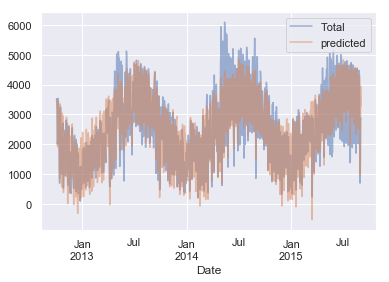

In [25]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [26]:
params = pd.Series(model.coef_, index=pd.concat([pd.Series(["Intercept"]),pd.Series(X.columns.values)]))
params

Intercept         34.314897
Mon              490.296158
Tue              596.243539
Wed              578.405151
Thu              468.195949
Fri              164.217455
Sat            -1116.446711
Sun            -1146.596643
holiday        -1184.393535
daylight_hrs     129.240672
PRCP            -663.374237
dry day          551.976034
Temp (C)          66.065583
dtype: float64

We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays.
We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home.
Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!